# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

#### Знакомство с данными

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import warnings
pd.set_option('display.max_columns', None)

In [2]:
# откроем файл и запросим основные характеристики
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
# посмторим на первые 5 строк датафрейма
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


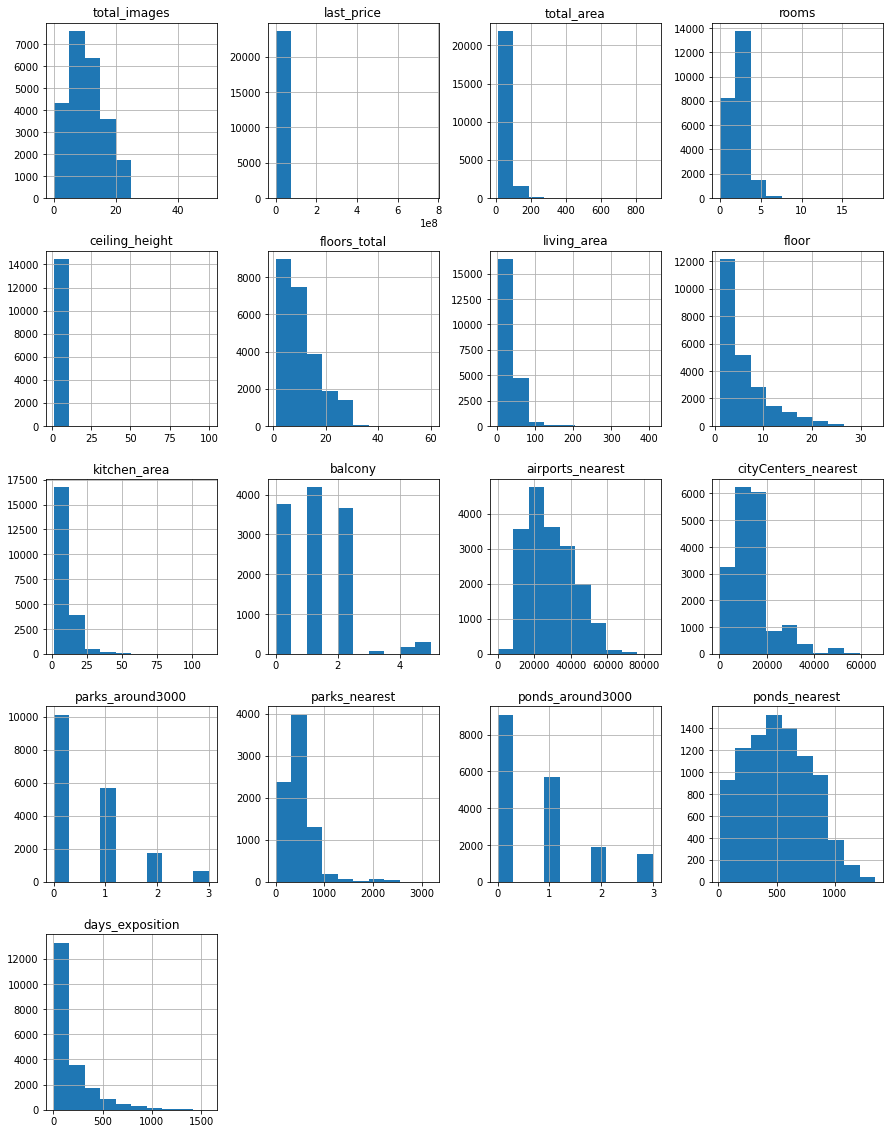

In [4]:
# построим гистограмму для всех числовых столбцов таблицы
data.hist(figsize=(15, 20));

In [5]:
# Сохраним начальное количество строк в датасете для последующего контроля доли отброшенных данных
data_rows_initially = data.shape[0]
data_rows_initially

23699

#### Выводы после предварительного знакомства с данными

В предоставленном нам файле содержатся данные о 23699 объектах недвижимости. Каждый объект описан 22-мя характеристиками, но данные содержат пропуски, которые могли возникнуть в результате опечаток, или по причине человеческого фактора. Например, если данная характеристика отстутсвует у объекта недвижимости, то продавец мог оставить соответствующую колонку пустой.

На гистограммах, описывающих высоту потолка и площадь кухни видно, что в данных присутствует незначительное количество записей со значениями около 100. Необходимо обратить внимание на эти столбцы на этапе предобработки данных.

### Предобработка данных

#### Заполнение пропусков и обработка аномальных значений

In [6]:
# найдем количество пропущенных значений в столбцах
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

##### Высота потолка

<u>Высоту потолка</u> можно заполнить медианным значением, т.к. при размещении объявления этому параметру могут не придавать особого значения, если высота с точки зрения продавца является обычной. 

Медианное значение лучше считать не по всему столбцу, а с учетом того, является ли квартира студией или нет, потому что высота потолка у студий обычно выше, чем высота потолка обычных квартир.

Прежде чем считать медианные значения высот, необходимо проверить наличие аномальных значений и скорректировать их. На гистограмме, которую мы построили выше, видно, что в столбце 'ceiling_height' есть значения, близкие к 100 м, что невозможно.

In [7]:
sorted(data['ceiling_height'].unique())

[1.0,
 2.0,
 2.3,
 2.4,
 2.45,
 2.46,
 2.48,
 2.53,
 2.59,
 2.62,
 2.63,
 2.7,
 nan,
 1.2,
 1.75,
 2.2,
 2.25,
 2.34,
 2.47,
 2.49,
 2.5,
 2.51,
 2.52,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.6,
 2.61,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.9,
 3.93,
 3.95,


Значения от 22,6 до 32,0 скорее всего результат опечатки. Их можно исправить, разделив на 10. Значения 100, 10.3, 14, 20 лучше заменить на медианные.

In [8]:
# исправляем значения от 22,6 до 32,0
data.loc[(22 < data['ceiling_height']) & (data['ceiling_height'] <= 32), 'ceiling_height'] \
= data.loc[(22 < data['ceiling_height']) & (data['ceiling_height'] <= 32), 'ceiling_height'] / 10

In [9]:
# Значения 100, 10.3, 14, 20 и пропуски заменяем на медианные.
for height in [10.3, 14, 20, 100]:
    data['ceiling_height'] = data['ceiling_height'].replace(height, np.nan)
data.loc[(data['studio'] == True) & (data['ceiling_height'].isna()), 'ceiling_height'] \
= data.loc[(data['studio'] == True),'ceiling_height'].median()
data.loc[(data['studio'] == False) & (data['ceiling_height'].isna()), 'ceiling_height'] \
= data.loc[(data['studio'] == False),'ceiling_height'].median()

In [10]:
# Сделаем проверку
data['ceiling_height'].isna().sum()

0

##### Жилая площадь и площадь кухни

Пропуски в данных о жилой площади и площади кухни заполним с помощью отношения интересующей нас площади ко всей площади квартиры.

In [11]:
# считаем отношение для жилой площади
living_area_ratio =\
data.query('not living_area.isna() and not total_area.isna()')['living_area'].mean()\
/data.query('not living_area.isna() and not total_area.isna()')['total_area'].mean()
living_area_ratio

0.5734446218294131

In [12]:
# заполняем пропуски
data.loc[data['living_area'].isna(), 'living_area'] = data['total_area'] * living_area_ratio

In [13]:
# считаем отношение для площади кухни
kitchen_ratio =\
data.query('not kitchen_area.isna() and not total_area.isna()')['kitchen_area'].mean()\
/data.query('not kitchen_area.isna() and not total_area.isna()')['total_area'].mean()
kitchen_ratio

0.17398892610297417

In [14]:
# заполняем пропуски
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data['total_area'] * kitchen_ratio
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Посмотрим теперь на общее описание данных о площади кухни. Судя по гистограмме, которую мы построили на первом шаге, там есть значения, близкие к 100 кв. м., что кажется неправдоподобным.

In [15]:
data['kitchen_area'].describe()

count    23699.000000
mean        10.499997
std          6.035287
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [16]:
data[data['kitchen_area'] > 30].shape[0]

367

Кухни с площадью более 30 кв. м. встречаются крайне редко (по данным сайта https://www.ndv.ru/ их около 0,1%). Скорее всего в этих 367 объявлениях кухня объединена с жилой комнатой. Это помешает сделать достоверный анализ, поэтому оставим только те объявления, где площадь кухни меньше 30 кв. м.

In [17]:
data = data.query('kitchen_area < 30')
data['kitchen_area'].describe()

count    23272.000000
mean         9.944435
std          4.118117
min          1.300000
25%          7.000000
50%          9.000000
75%         11.600000
max         29.900000
Name: kitchen_area, dtype: float64

##### Балконы, парки и пруды

In [18]:
# Если продавец не указал число балконов, то, скорее всего, их нет.
# Аналогично с числом парков и прудов в радиусе 3000 м
# Заполним пропуски нулем и сделаем проверку
data['balcony'] = data['balcony'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)


(
    data['balcony'].isna().sum(), 
    data['ponds_around3000'].isna().sum(), 
    data['parks_around3000'].isna().sum()
)

(0, 0, 0)

##### Апартаменты

In [19]:
# Если в графе 'is_apartment' продавец ничего не указал, 
# значит можно считать, что данный объект не является апартаментами. 
# Посмотрим, какие значения хранятся в данном столбце. 
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [20]:
# Заполним пропуски значением False и сделаем проверку
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

##### Количество этажей в доме и длительность размещения объявления

<u>Как долго было размещено объявление</u> можно было бы посчитать с момента размещения до момента, когда собран датасет, но этого времени мы не знаем. <u>Общее число этажей</u> не получается определить по этажу, на котором размещена квартира, потому что там попадаются различные значения от 1 до 22. 

Так как нам предстоит добавлять новый столбец с типом этажа, то строки, содержащие пропуски, удалим.

Пропуски в данных о сроках размещения объявления оставим как есть.

In [21]:
# удаляем строки, содержащие пропуски в столбцах floors_total и days_exposition
data = data.dropna(subset = ['floors_total']).reset_index(drop=True)
data['floors_total'].isna().sum()

0

##### Расстояния до аэропорта, центра, парка и пруда

<u>Пропуски</u> в данных о <u>расстояниях до аэропорта и центра населенного пункта</u>.

В тех случаях, где расстояние до аэропорта не указано ни в одном объявлении, можно сказать, что аэропорта в данном населенном пункте нет. 

Считаю, что лучше оставить значение пустым, потому что 0 в данном случае может быть понят как максимальное близкое расстояние до аэропорта (например, если квартира находится в ЖК Зеленый квартал на Пулковских высотах)

Аналогично <u>не будем заполнять нулем</u> пропуски в данных о расстоянии <u>до центра населенного пункта, до ближайшего парка и пруда</u>.

##### Количество комнат

Посмотрим на аномальные значения в данных о количестве комнат

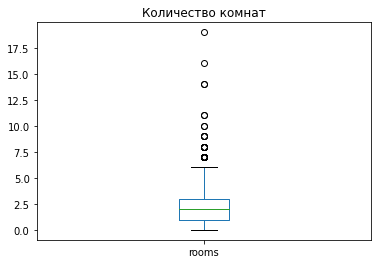

In [22]:
data['rooms'].plot(kind='box',title='Количество комнат');

Посмотрим, какую часть от общего числа квартир занимают те, которые имеют больше 6 комнат (отмечены точками за пределами усов)

In [23]:
data.query('rooms >= 6').shape[0]

152

In [24]:
data.query('rooms >= 6').shape[0] / data.shape[0]

0.006555397420968646

Можно удалить их без потери качества данных

In [25]:
data = data.query('rooms < 6')
data.shape

(23035, 22)

##### Цена объекта

Для большей наглядности разделим цену на 1 000 000

In [26]:
prices = data['last_price'] / (10**6)
prices.describe()

count    23035.000000
mean         5.847818
std          6.005359
min          0.430000
25%          3.400000
50%          4.580000
75%          6.500000
max        401.300000
Name: last_price, dtype: float64

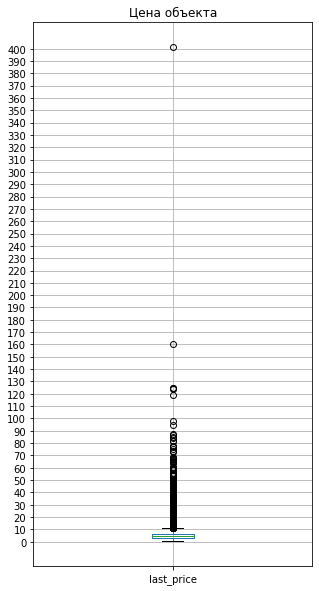

In [27]:
# Поищем на графике аномальные значения.
prices.plot(
    kind='box', 
    figsize=(5, 10),
    yticks=[x*10 for x in range(0, 41)],
    grid=True,
    title='Цена объекта'
);

Проведем расчеты, чтобы узнать, какую часть объявлений можно удалить без потери качества данных

In [28]:
data.query('last_price > 15*10**6').shape[0]

799

In [29]:
data.query('last_price > 15*10**6').shape[0] / data.shape[0] * 100

3.4686346863468636

Это меньше 4 % от всех имеющихся значений. Удалим их

In [30]:
data = data.query('last_price <= 15*10**6')

Рассчитаем, какой процент исходных данных остался после всех удалений отсутствующих значений.

In [31]:
data.shape[0] / data_rows_initially * 100

93.8267437444618

Потери данных составляют менее 10. Можно продолжать анализ

#### Устранение неявных дубликатов

In [32]:
# посмотрим повторы в столбце locality_name
# количество названий
len(data['locality_name'].unique())

364

In [33]:
# выведем список уникальных значений
pd.set_option('display.max_rows', 365)
data['locality_name'].value_counts()

Санкт-Петербург                                            14347
посёлок Мурино                                               519
посёлок Шушары                                               437
Всеволожск                                                   394
Пушкин                                                       345
Колпино                                                      337
посёлок Парголово                                            326
Гатчина                                                      306
деревня Кудрово                                              298
Выборг                                                       234
Петергоф                                                     197
Красное Село                                                 174
Сестрорецк                                                   174
Кудрово                                                      170
Сертолово                                                    142
деревня Новое Девяткино  

In [34]:
# напишем функцию, котрая убирает тип населенного пункта из значений столбца 'locality_name'
def clean_localty_name(row):
    try:
        if 'ё' in row:
            row = row.replace('ё', 'е')
        if 'станции' in row:
            row = row.replace('станции', 'станция')
        localty_types = [
            'поселок при железнодорожной ',
            'при железнодорожной ',
            'поселок городского типа ',
            'городской поселок ',
            'коттеджный поселок ',
            'поселок ',
            'деревня ',
            'село ',
            'садовое товарищество ',
            'садоводческое некоммерческое товарищество '
        ]
        for l_type in localty_types:
            if l_type in row:
                return row[len(l_type):]
        return row
    except:
        return row

In [35]:
# создадим новый столбец, в который поместим название населенного пункта
data['locality_name_cleaned'] = data['locality_name'].apply(clean_localty_name)
pd.set_option('display.max_rows', 400)
data['locality_name_cleaned'].value_counts(), len(data['locality_name_cleaned'].unique())

(Санкт-Петербург            14347
 Мурино                       585
 Кудрово                      468
 Шушары                       437
 Всеволожск                   394
 Пушкин                       345
 Колпино                      337
 Парголово                    326
 Гатчина                      306
 Выборг                       234
 Петергоф                     197
 Красное Село                 174
 Сестрорецк                   174
 Новое Девяткино              142
 Сертолово                    142
 Ломоносов                    133
 Кириши                       125
 Бугры                        113
 Сланцы                       112
 Волхов                       111
 Тосно                        104
 Кингисепп                    103
 Кронштадт                     95
 Никольское                    94
 Коммунар                      88
 Сосновый Бор                  86
 Кировск                       84
 Отрадное                      79
 Янино-1                       67
 Приозерск    

Число уникальных значений в loyalty_name сократилось с 364 до 306 

In [36]:
# пропуски в названиях населенных пунктов заполним пустыми строками
data['locality_name_cleaned'] = data['locality_name_cleaned'].fillna('')
data['locality_name_cleaned'].isna().sum()

0

#### Изменение типа данных в столбцах

In [37]:
# посмотрим еще раз на информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22236 entries, 0 to 23186
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_images           22236 non-null  int64  
 1   last_price             22236 non-null  float64
 2   total_area             22236 non-null  float64
 3   first_day_exposition   22236 non-null  object 
 4   rooms                  22236 non-null  int64  
 5   ceiling_height         22236 non-null  float64
 6   floors_total           22236 non-null  float64
 7   living_area            22236 non-null  float64
 8   floor                  22236 non-null  int64  
 9   is_apartment           22236 non-null  bool   
 10  studio                 22236 non-null  bool   
 11  open_plan              22236 non-null  bool   
 12  kitchen_area           22236 non-null  float64
 13  balcony                22236 non-null  float64
 14  locality_name          22192 non-null  object 
 15  ai

Тип данных float32 занимает в памяти меньше места, чем float64, но его возможностей по представлению чисел и точности расчетов хватит для наших данных. Поэтому преобразуем float64 к float32.

In [38]:
data = data.astype({
    'total_area': 'float32',
    'ceiling_height': 'float32',
    'living_area': 'float32',
    'kitchen_area': 'float32',
    'airports_nearest': 'float32',
    'cityCenters_nearest': 'float32',
    'parks_nearest': 'float32',
    'ponds_nearest': 'float32',
    'days_exposition': 'float32'
})

Можно преобразовать столбец с <u>ценой</u> к целочисленному типу, потому что цены  на недвижимость не содержат копеек. <u>Количество этажей, балконов, парков, прудов, а также количество дней</u>, в течение которых размещено объявление, тоже всегда целое число.

In [39]:
data = data.astype({
    'last_price': 'int',
    'balcony': 'int',
    'floors_total': 'int',
    'parks_around3000': 'int',
    'ponds_around3000': 'int',
})
# столбец days_exposition содержит пропуски, обработаем его отдельно
data['days_exposition'] = data['days_exposition'].dropna().astype(int)

Значения в столбце 'first_day_exposition' переведем в тип datetime. Все значения в этом столбце заканчиваются 'T00:00:00', потому что нам не важно время, в которое размещено объявление, только день

In [40]:
# переведем данные 'first_day_exposition' в datetime
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'],
    format='%Y-%m-%dT%H:%M:%S'
)

In [41]:
# проверим результат
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22236 entries, 0 to 23186
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   total_images           22236 non-null  int64         
 1   last_price             22236 non-null  int64         
 2   total_area             22236 non-null  float32       
 3   first_day_exposition   22236 non-null  datetime64[ns]
 4   rooms                  22236 non-null  int64         
 5   ceiling_height         22236 non-null  float32       
 6   floors_total           22236 non-null  int64         
 7   living_area            22236 non-null  float32       
 8   floor                  22236 non-null  int64         
 9   is_apartment           22236 non-null  bool          
 10  studio                 22236 non-null  bool          
 11  open_plan              22236 non-null  bool          
 12  kitchen_area           22236 non-null  float32       
 13  b

#### Итоги предобработки данных

В ходе предобработки данных мы:

1. обработали аномальные значения в столбцах с высотой потолка, площадью кухни, количеством комнат и ценой объекта: часть данных отбросили, часть заполнили медианным значением;

1. обработали пропуски в данных о высоте потолка, площади кухни, количестве балконов, прудов и парков в радиусе меньше 3000 м, расстоянии до аэропорта и центра населенного пункта, жилой площади, общем количестве этажей и о количестве дней, в течение которых размещено объявление: часть данных удалили, заполнили нулем или медианным значением по подходящей группе значений;

1. обработали неявные дубликаты: создали отдельный столбец, куда поместили только название населенного пункта, без указания его типа (полная информация доступна в столбце localty_name);

1. изменили типы данных в столбцах на удобный для работы формат времени, целочисленный тип или более компактный вещественный.



### Посчитайте и добавьте в таблицу новые столбцы

In [42]:
# Цена за квадратный метр
data['price_per_sq_meter'] = data['last_price'] / data['total_area']

In [43]:
# день недели публикации объявления
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

In [44]:
# месяц, в котором опубликовано объявление
data['month_exposition'] = data['first_day_exposition'].dt.month

In [45]:
# год, в котором опубликовано объявление
data['year_exposition'] = data['first_day_exposition'].dt.year

In [46]:
# тип этажа квартиры: первый, последний, другой
def define_floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

data['floor_type'] = data.apply(define_floor_type, axis=1)

In [47]:
# расстояние до центра в км
data['cityCenters_km'] = round(data['cityCenters_nearest'] // 1000, 0).dropna().astype(int)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_cleaned,price_per_sq_meter,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_km
0,20,13000000,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,120370.370370,3,3,2019,другой,16.0
1,7,3350000,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,82920.788947,1,12,2018,первый,18.0
2,10,5196000,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,92785.714286,3,8,2015,другой,13.0
4,10,2890000,30.400000,2018-09-10,1,2.65,12,14.400000,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,Янино-1,95065.790667,0,9,2018,другой,NaN
5,6,3700000,37.299999,2017-11-02,1,2.65,26,10.600000,6,False,False,False,14.4,1,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,Парголово,99195.712485,3,11,2017,другой,19.0


Мы рассчитали и поместили в новые столбцы данные о дополнительных характеристиках объектов недвижимости. На следующем шаге проанализируем их влияние на цену жилья.

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b> 
<br>Все необходимые колонки добавлены. Идём дальше)
</div>

### Проведите исследовательский анализ данных

#### Общая площадь объектов

In [48]:
data.query('total_area > 150').shape[0]

53

Так как число объектов с площадью более 150 км незначительно, отбросим их при построении графика для увеличения его наглядности.

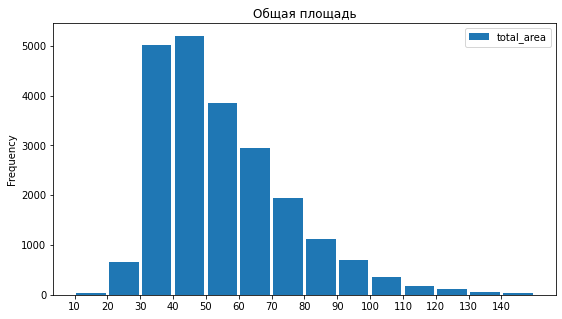

In [49]:
data.plot(
    kind='hist',
    y='total_area',
    bins=14,
    rwidth=0.9,
    range=(10, 150),
    figsize=(9, 5),
    xticks = [x*10 for x in range(1, 15)],
    title='Общая площадь'
);

Большинство квартир имеют площадь от 30 до 50 кв. м. С ростом площади количество предложений на рынке недвижимости снижается.

#### Жилая площадь объектов

In [50]:
data.query('total_area > 150').shape[0]

53

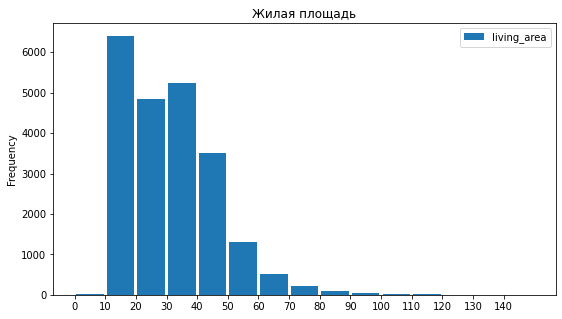

In [51]:
data.plot(
    kind='hist',
    y='living_area',
    bins=15,
    rwidth=0.9,
    range=(0, 150),
    figsize=(9, 5),
    xticks = [x*10 for x in range(0, 15)],
    title='Жилая площадь'
);

Большинство квартир имеют жилую площадь от 10 до 40 кв. м. В целом распределение числа предложений по жилой площади повторяет распределение для общей площади.

#### Площадь кухни

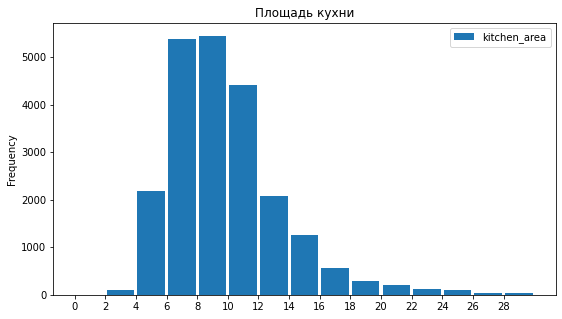

In [52]:
data.plot(
    kind='hist',
    y='kitchen_area',
    bins=15,
    rwidth=0.9,
    range=(0, 30),
    figsize=(9, 5),
    xticks = [x*2 for x in range(0, 15)],
    title='Площадь кухни'
);

Большинство квартир имеют кухню площадью от 6 до 12 кв.м.

#### Цена объекта

In [53]:
prices = data['last_price'] / (10 ** 6)
prices.describe()

count    22236.000000
mean         5.112280
std          2.659280
min          0.430000
25%          3.350000
50%          4.500000
75%          6.230787
max         15.000000
Name: last_price, dtype: float64

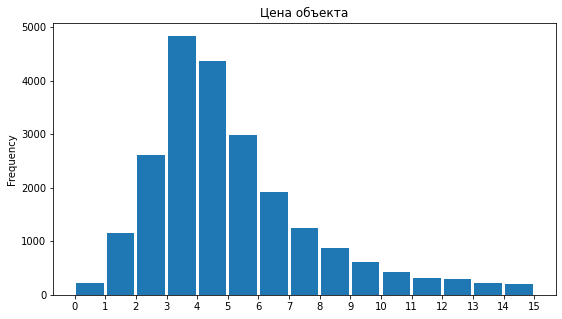

In [54]:
prices.plot(
    kind='hist',
    bins=15,
    rwidth=0.9,
    range=(0, 15),
    figsize=(9, 5),
    xticks = [x for x in range(0, 16)],
    title='Цена объекта'
);

Большинство квартир продаются по цене от 3 до 5 млн рублей. Медианное значение цены на квартиру 4,5 млн. р.

#### Количество комнат

In [55]:
data['rooms'].describe()

count    22236.000000
mean         1.965506
std          0.928972
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64

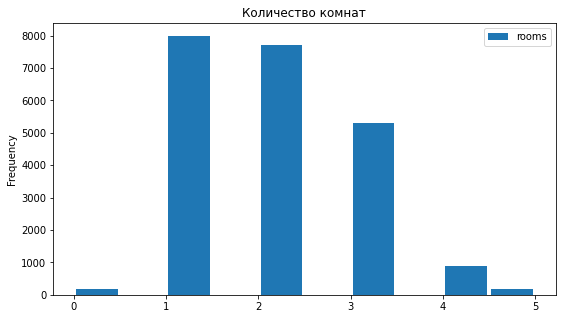

In [56]:
data.plot(
    kind='hist',
    y='rooms',
    rwidth=0.9,
    figsize=(9, 5),
    xticks=[x for x in range(0, 6)],
    title='Количество комнат'
);

Большинство квартир имеют от 1 до 3 комнат.

#### Высота потолков

In [57]:
data.query('ceiling_height < 2 or ceiling_height > 4.5').shape[0]

12

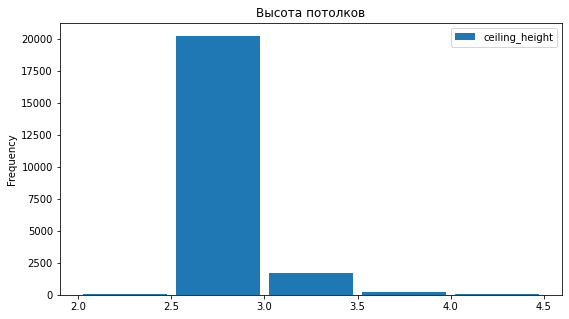

In [58]:
data.plot(
    kind='hist',
    y='ceiling_height',
    bins=5,
    rwidth=0.9,
    range=(2, 4.5),
    figsize=(9, 5),
    title='Высота потолков'
);

Практически все квартиры имеют высоту потолка от 2,5 до 3 м.

#### Этаж квартиры

In [59]:
data.query('floor > 25').shape[0]

40

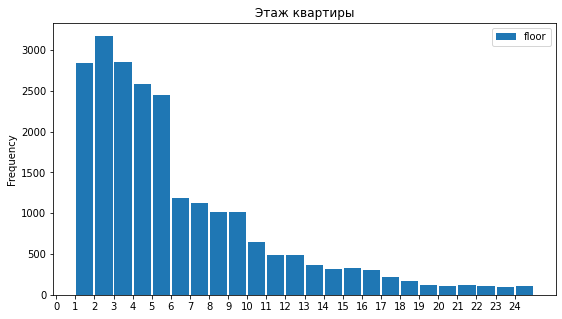

In [60]:
data.plot(
    kind='hist',
    y='floor',
    bins=24,
    rwidth=0.9,
    range=(1, 25),
    figsize=(9, 5),
    xticks = [x for x in range(0, 25)],
    title='Этаж квартиры'
);

Основная масса квартир расположена с 1-го по 5-й этаж.

#### Тип этажа квартиры

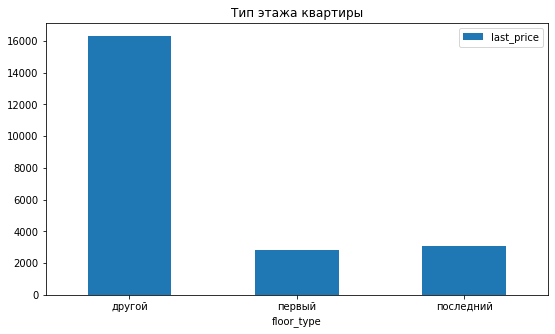

In [61]:
data.pivot_table(
    index='floor_type',
    values='last_price',
    aggfunc='count'
).plot(
    kind='bar',
    figsize=(9, 5),
    rot=0,
    title='Тип этажа квартиры'
);

In [62]:
data.groupby(data['floor_type'])['last_price'].count()

floor_type
другой       16315
первый        2835
последний     3086
Name: last_price, dtype: int64

Число квартир, расположенных на первом и последнем этажах, примерно в 3 раза меньше, чем всех остальных предложений. 

#### Общее количество этажей в доме

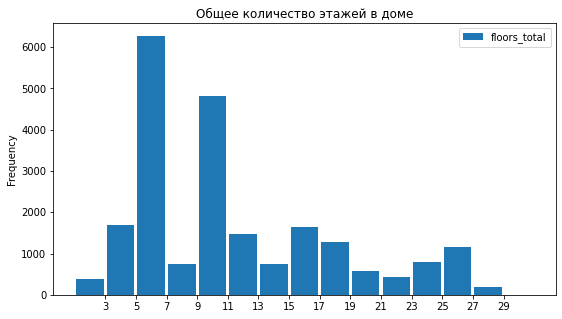

In [63]:
data.plot(
    kind='hist',
    y='floors_total',
    bins=15,
    rwidth=0.9,
    range=(1, 31),
    figsize=(9, 5),
    xticks = [1+x*2 for x in range(1, 15)],
    title='Общее количество этажей в доме'
);

Большинство квартир расположены в 5ти- и 9ти-этажных домах

#### Расстояние до центра города в метрах

In [64]:
data['cityCenters_nearest'].describe()

count    16762.000000
mean     14704.187500
std       8557.907227
min        208.000000
25%      10232.500000
50%      13402.500000
75%      16556.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

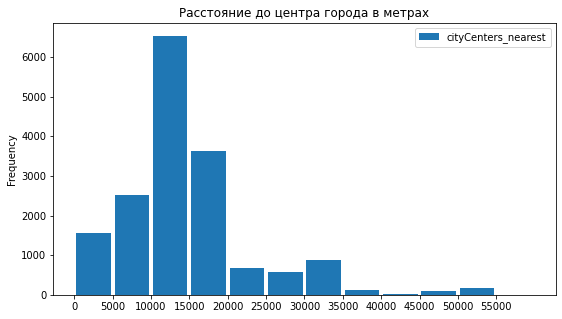

In [65]:
data.plot(
    kind='hist',
    y='cityCenters_nearest',
    bins=12,
    rwidth=0.9,
    range=(0, 60000),
    figsize=(9, 5),
    xticks = [x*5000 for x in range(0, 12)],
    title='Расстояние до центра города в метрах'
);

Большая часть квартир находится на расстоянии от 10 до 15 км от центра населенного пункта.

#### Расстояние до ближайшего аэропорта

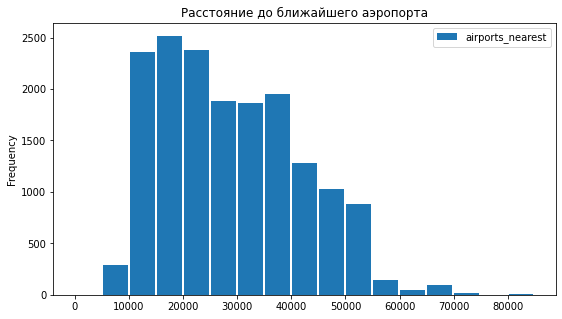

In [66]:
data.plot(
    kind='hist',
    y='airports_nearest',
    bins=17,
    rwidth=0.9,
    figsize=(9, 5),
    xticks = [x*10_000 for x in range(0, 9)],
    title='Расстояние до ближайшего аэропорта'
);

Основная масса объектов недвижимости находится на расстоянии от 10 до 40 км от ближайшего аэропорта.

#### Расстояние до ближайшего парка

In [67]:
# Посчитаем процент объявлений, для которых указано расстояние до ближайшего пруда.
data['parks_nearest'].describe()['count'] / data.shape[0] * 100

32.03363914373089

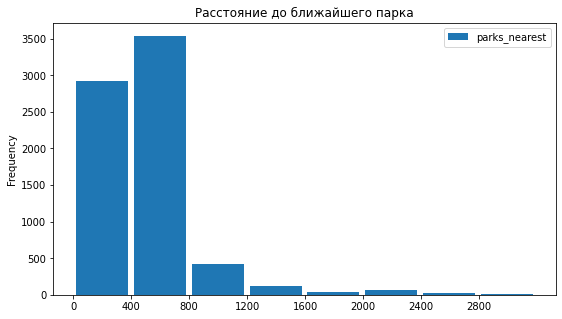

In [68]:
data.plot(
    kind='hist',
    y='parks_nearest',
    bins=8,
    rwidth=0.9,
    figsize=(9, 5),
    xticks = [x*400 for x in range(0, 8)],
    title='Расстояние до ближайшего парка'
);

Расстояние до ближайшего пруда указано только в трети объявлений. Из них большинство находится на расстоянии меньше 800 м до водоема.

#### День и месяц публикации объявления

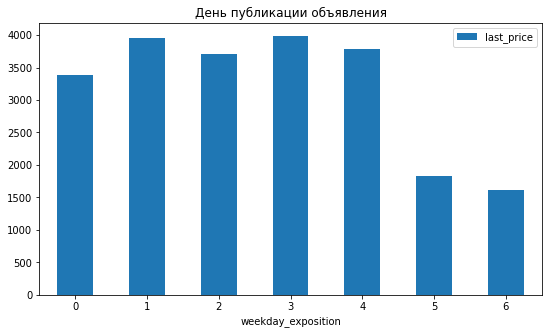

In [69]:
data.pivot_table(
    index='weekday_exposition',
    values='last_price',
    aggfunc='count'
).plot(
    kind='bar',
    figsize=(9, 5),
    rot=0,
    title='День публикации объявления'
);

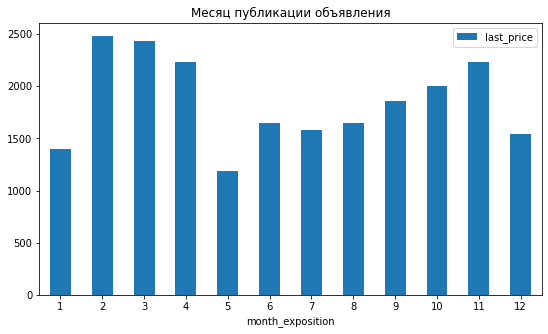

In [70]:
data.pivot_table(
    index='month_exposition',
    values='last_price',
    aggfunc='count'
).plot(
    kind='bar',
    figsize=(9, 5),
    rot=0,
    title='Месяц публикации объявления'
);

В будние дни размещается больше объявлений, чем в выходные. В течение года меньше всего объявлений публикуют в мае и зимой – в декабре и январе. Возможно это вызвано большим количеством выходных дней и подготовкой к праздникам.

#### Как быстро продавались квартиры

In [71]:
data['days_exposition'].describe()

count    19460.000000
mean       175.557657
std        213.957566
min          1.000000
25%         44.000000
50%         92.000000
75%        223.000000
max       1580.000000
Name: days_exposition, dtype: float64

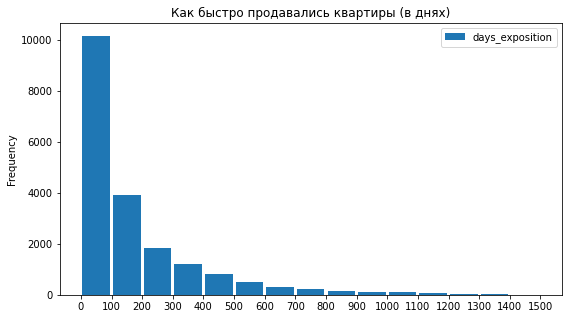

In [72]:
data.plot(
    kind='hist',
    y='days_exposition',
    bins=15,
    rwidth=0.9,
    range=(0, 1500),
    figsize=(9, 5),
    xticks = [x*100 for x in range(0, 16)],
    title='Как быстро продавались квартиры (в днях)'
);

Большинство квартир продаются в течение 100 дней, реже за 200 дней. Быстрые продажи – менее 45 дней. Таких всего 25 %. Долгие – более 220 дней. Таких случаев в данных тоже 25 %.

#### Какие факторы влияют на общую стоимость объекта

In [73]:
# отберем данные с количественными параметрами
df = data[[
    'last_price',       
    'total_area', 
    'ceiling_height', 
    'living_area', 
    'kitchen_area',
    'airports_nearest',
    'cityCenters_nearest',
    'parks_nearest',
    'ponds_nearest',
    'days_exposition',
    'price_per_sq_meter'
]
]
# посмотрим на коэффициенты кореляции цены с количественными параметрами
df.corr()['last_price'].sort_values(ascending=False)

last_price             1.000000
total_area             0.738731
living_area            0.635990
price_per_sq_meter     0.626848
kitchen_area           0.558232
ceiling_height         0.359552
days_exposition        0.105832
parks_nearest          0.049369
airports_nearest      -0.040332
ponds_nearest         -0.067101
cityCenters_nearest   -0.357414
Name: last_price, dtype: float64

Самый высокий коэффициент корреляции с ценой у <u>общей площади квартиры, жилой площади, цены за квадратный метр, площади кухни и высоты потолка</u>. С ростом этих параметров растет и цена. 

Судя по этой таблице, влияние на цену оказывает и <u>расстояние до центра населенного пункта</u>, но здесь зависимость обратная: при увеличении расстояния цена снижается.

Проиллюстрируем это на графиках

In [74]:
titles = {
    'total_area': 'Общая площадь',
    'living_area': 'Жилая площадь',
    'price_per_sq_meter': 'Цена за квадратный метр',
    'kitchen_area': 'Площадь кухни',
    'ceiling_height': 'Высота потолка',
    'cityCenters_nearest': 'Расстояние до центра'
}

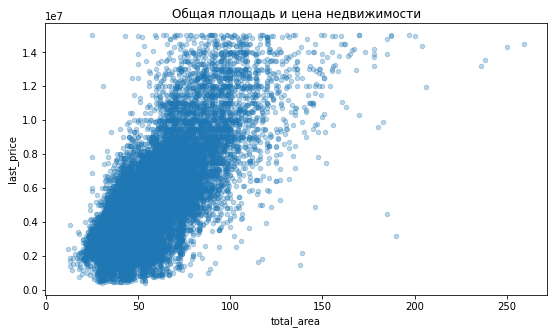

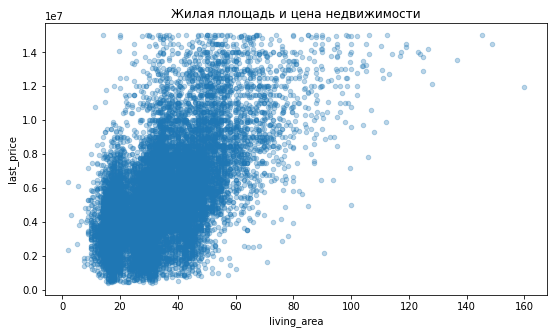

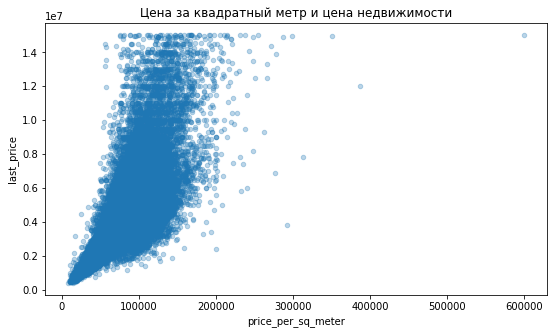

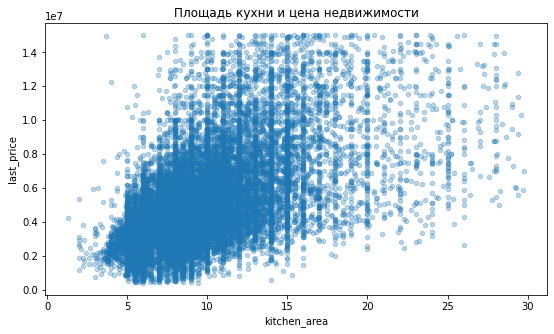

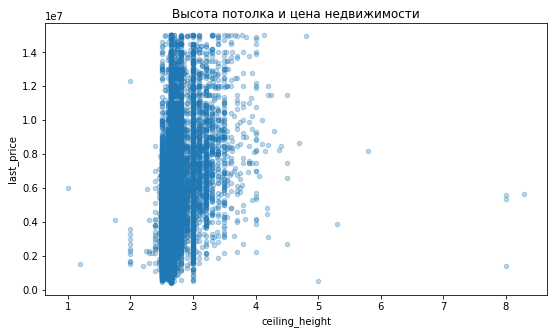

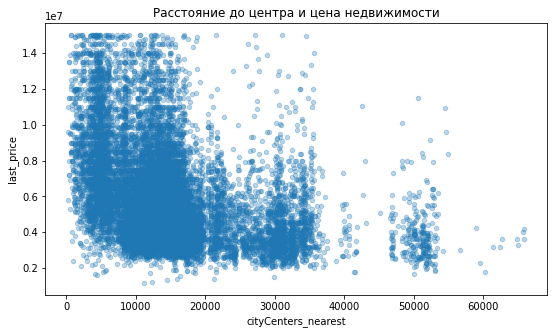

In [75]:
for key in titles:
    data.sort_values('total_area').plot(
        x=key,
        y='last_price',
        kind='scatter',
        alpha=0.3,
        figsize=(9, 5),
        title=titles[key]+' и цена недвижимости'
    );

Проанализируем теперь категориальные переменные. Для них корректно считать коэффициент корреляции, потому что данные не числовые, а категориальные. Для них рассчитаем среднюю цену по категории и отобразим на подходящей диаграмме.

##### Количество комнат и цена

Для анализа связи количества комнат и ценой квартиры построим график средних цен для разного количества комнат.

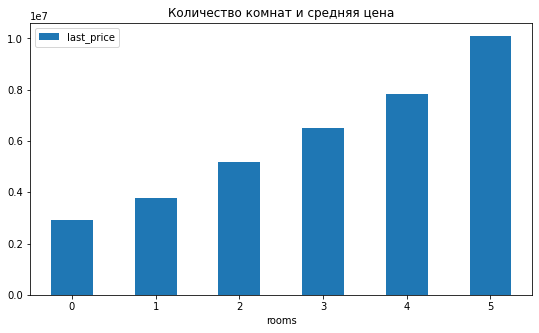

In [76]:
data.pivot_table(
    index='rooms',
    values='last_price',
    aggfunc='mean'
).plot(
    kind='bar',
    figsize=(9, 5),
    rot=0,
    title='Количество комнат и средняя цена'
);

На графике видно наличие связи между количеством комнат и ценой квартиры: с ростом числа комнат квартиры обычно растёт и ее цена.

##### Тип этажа и цена

Посмотрим на среднюю стоимость квартиры в зависимости от типа этажа.

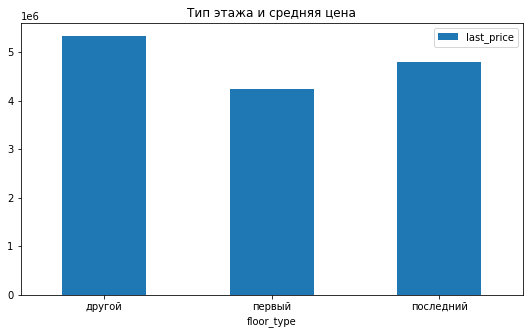

In [77]:
data.pivot_table(
    index='floor_type',
    values='last_price',
    aggfunc='mean'
).plot(
    kind='bar',
    figsize=(9, 5),
    rot=0,
    title='Тип этажа и средняя цена'
);

Цена на квартиры на первом этаже ниже цен квартир на других этажах. Квартиры, расположенные на последнем этаже  дешевле квартир, расположенных между первым и последним этажами, но разница не так велика, как для первых этажей.

#### День, месяц, год публикации и цена

Для анализа связи между датой публикации объявления построим несколько графиков средней цены по дням недели, месяцу и году.

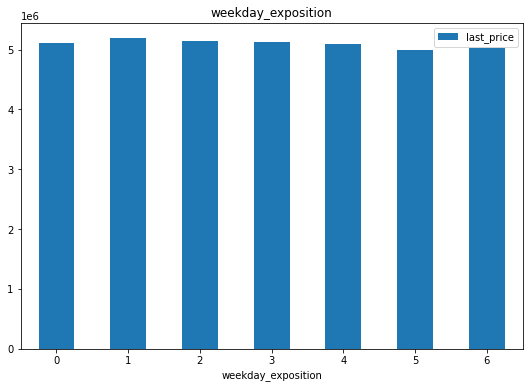

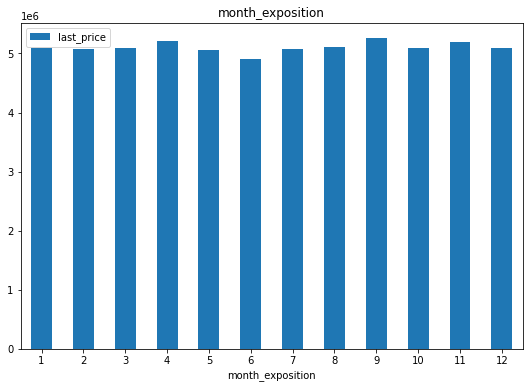

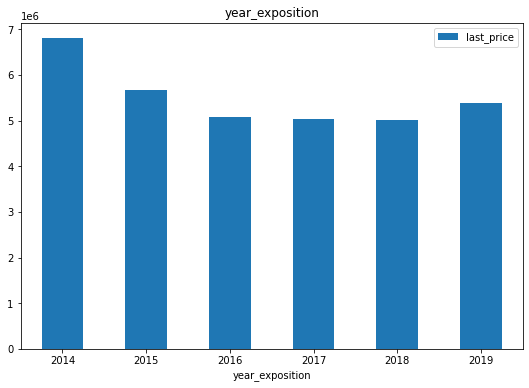

In [78]:
category_list = [
    'weekday_exposition', 
    'month_exposition',
    'year_exposition'
]
for param in category_list:
    data.pivot_table(
        index=param,
        values='last_price',
        aggfunc='mean'
    ).plot(
        kind='bar',
        figsize=(9, 6),
        rot=0,
        title=param
    );

На графике средней цены по годам видно, что самые высокие цены были в 2014 году, снижались до 2016 и три года были стабильны. Рост наметился только в 2019 году.

#### Средняя цена квадратного метра

Цена за квадратный метр – один из показателей, влияющих на цену. Но он отличается в разных населенных пунктах. Кроме того, в крупных городах он может отличаться в зависимости от расстояния до центра. Изучим эти показатели подробнее.

Посчитаем среднюю цену одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений.

In [79]:
# Получим список 10 населенных пунктов с наибольшим числом объявлений
ten_lasgest = data.pivot_table(
    index='locality_name_cleaned',
    values='last_price',
    aggfunc='count'
).sort_values('last_price', ascending=False).index[:10]
ten_lasgest

Index(['Санкт-Петербург', 'Мурино', 'Кудрово', 'Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'Парголово', 'Гатчина', 'Выборг'],
      dtype='object', name='locality_name_cleaned')

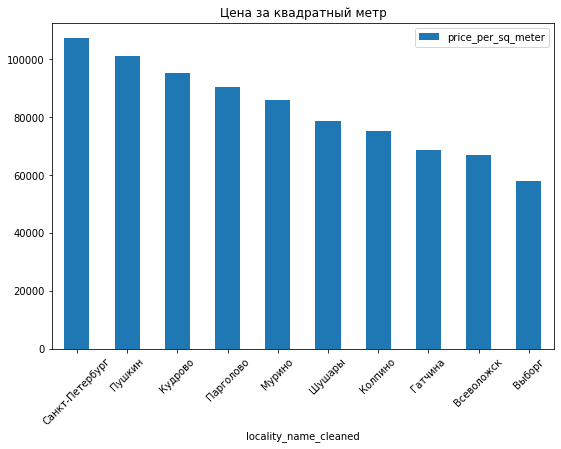

In [80]:
# Рассчитаем цену одного квадратного метра в этих населенных пунктах
(
    data.query('locality_name_cleaned in @ten_lasgest')
    .pivot_table(
        index='locality_name_cleaned',
        values='price_per_sq_meter',
        aggfunc='mean'
    )
    .sort_values(
        'price_per_sq_meter',
        ascending=False
    )
    .plot(
        kind='bar',
        figsize=(9, 6),
        rot=45,
        title='Цена за квадратный метр'
    )
);

Самые высокие показатели имеют Санкт-Петербург и Пушкин, самые низкие – Гатчина и Выборг.

#### Влияние удаленности от центра на цену

Сравним коэффициент корреляции между ценой и расстоянием до центра в Санкт-Петербурге и в остальных населенных пунктах.

In [81]:
# для Санкт-Петербурга
data.query(
    'locality_name_cleaned == "Санкт-Петербург"'
)['last_price'].corr(
    data.query('locality_name_cleaned == "Санкт-Петербург"')['cityCenters_km']
              )

-0.39170684788619153

In [82]:
# для других населенных пунктов
data.query(
    'locality_name_cleaned != "Санкт-Петербург"'
)['last_price'].corr(
    data.query('locality_name_cleaned != "Санкт-Петербург"')['cityCenters_km']
              )

-0.06632872862130121

Видим, что расстояние до центра в Санкт-Петербурге в несколько раз больше оказывает влияние на конечную стоимость недвижимости, чем в других населенных пунктах. Изучим эту зависимость подробнее.

#### Средняя цена каждого километра в Санкт-Петербурге

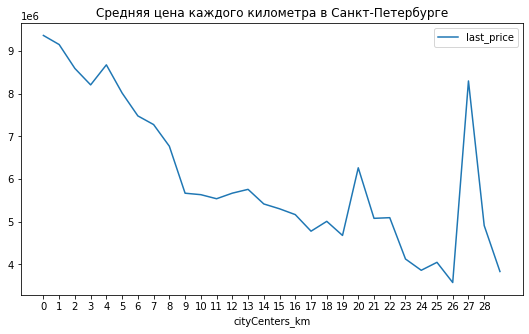

In [83]:
# Рассчитаем среднюю цену квадратного метра в зависимости от удаленности квартиры от центра
# и построим график
data.query(
    'locality_name_cleaned == "Санкт-Петербург"'
).pivot_table(
    index='cityCenters_km',
    values='last_price',
    aggfunc='mean'
).plot(
    figsize=(9, 5),
    xticks=[x for x in range(0, 29)],
    title='Средняя цена каждого километра в Санкт-Петербурге'
);

На графике видно, что средняя цена очень высока в центре Санкт-Петербурга и уменьшается по мере удаления от него. Самая дорогостоящая недвижимость находится в радиусе менее 9 км от центра.

На расстоянии 20 и 27 км от центра видим резкие скачки цен. Возможные причины этого:
- близость аэропорта (метро до Пулково нет, всегда приходится добираться с пересадками)
- близость КАД (восточное полукольцо проходит примерно на расстоянии 21 км от центра) или наличие концевых станций линий метрополитена (это важно для людей, которые хотят работать в СПб, но по какой-либо причине не могут жить в центре и поэтому может возникать повышенный спрос на эти квартиры)
- где-то на этом расстоянии построен дорогой комфортабельный ЖК или бизнес-центр.

Информации датасета для проверки этих гипотез недостаточно, необходимо провести дополнительный сбор данных.


### Общий вывод

Для проведения исследования были проведены: обработка данных, расчет дополнительных характеристик и предварительный анализ данных.

Цель – выявить интересные особенности и зависимости, которые существуют на рынке недвижимости.

Основная задача – выявить список параметров, оказывающих влияние на конечную стоимость объекта недвижимости. В дальнейшем их можно использовать для построения автоматизированной системы, способной рассчитывать цену объекта по его характеристикам.

В ходе предобработки данных мы обработали аномальные значения, пропуски в данных, неявные дубликаты и изменили типы данных для большего удобства проведения анализа. Потери данных при удалении пропусков составили меньше 7 %.

В ходе предварительного анализа данных удалось выявить параметры, оказывающие влияние на конечную цену. <u>Список характеристик</u> для разработки автоматизированной системы:

- общая площадь (прямо пропорциональная зависимость)
- жилая площадь (прямо пропорциональная зависимость)
- цена за квадратный метр. Она зависит от населенного пункта. Десятка самых популярных (отсортирована по уменьшению цены за квадратный метр): Санкт-Петербург, Пушкин, Кудрово, Парголово, Мурино, Шушары, Колпино, Всеволожск, Гатчина и Выборг.
- площадь кухни (прямо пропорциональная зависимость)
- высота потолка (прямо пропорциональная зависимость)
- расстояние до центра, особенно для Санкт-Петербурга (обратно пропорциональная зависимость)
- количество комнат (прямо пропорциональная зависимость)
- тип этажа (первый и последний менее привлекательны)
- год публикации объявления (зависимость нелинейная, но наблюдается изменение средней цены на недвижимость в зависимости от года)